In [ ]:
import pandas as pd
import numpy as np
import os
import random
import pickle
import time

from numpy.random import randn
from scipy.interpolate import interp1d
import scipy.stats as stats

import keras
import tensorflow as tf

# lstm autoencoder recreate sequence
from numpy import array
from keras import optimizers
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.utils import plot_model
from keras.activations import sigmoid
from keras.activations import relu
from keras import backend as K

import matplotlib.pyplot as plt
import pydot
import keras.utils.vis_utils as vis_utils
vis_utils.pydot = pydot

import seaborn as sn
from sklearn import svm
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.utils import *
from sklearn.manifold import *
from scipy import io  

from scipy.io import loadmat

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive


In [ ]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
!K.tensorflow_backend._get_available_gpus()

2.12.0
2.12.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6838097319565179346
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14343274496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13927119810819034790
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
# Mount the Google Drive to access data: 

drive.mount('/content/drive')

# Load the CSV file into a Pandas DataFrame for training: 
xdata= pd.read_csv('/content/drive/My Drive/anchored_training_input.csv')
ydata=pd.read_csv('/content/drive/My Drive/anchored_training_output.csv')


# Load the CSV file into a Pandas DataFrame for testing: 
testing_input= pd.read_csv('/content/drive/My Drive/validation_input_anchored.csv')
testing_output=pd.read_csv('/content/drive/My Drive/validation_output_anchored.csv')



Mounted at /content/drive


In [ ]:
#Data preprocessing for training set:

x = xdata.values #converts the data in the xdata variable into a NumPy array
x = x.astype('float32') #converts the data type of the array to float32 for better machine learning performance
y = ydata.values  #converts the data in the xdata variable into a NumPy array
y = y.astype('float32') #converts the data type of the array to float32 for better machine learning performance

# Columns to remove (4, 5, 7, 8)
columnsx_to_remove = [1, 3, 4, 5, 7, 8]
columnsy_to_remove = [1, 3, 4, 5, 7,8]

# Remove the specified columns from the array
x_filtered = np.delete(x, columnsx_to_remove, axis=1)
y_filtered = np.delete(y, columnsy_to_remove, axis=1)

#Data preprocessing for testing set:
test_x = testing_input.values #converts the data in the xdata variable into a NumPy array
testing_x = test_x.astype('float32') #converts the data type of the array to float32 for better machine learning performance
test_y = testing_output.values #converts the data in the xdata variable into a NumPy array
testing_y = test_y.astype('float32') #converts the data type of the array to float32 for better machine learning performance




In [ ]:
#Data preprocessing for the LSTM architecture: 

# Reshape the data into 3 sequences or samples with 10000 time steps each and 1 feature (acceleration through one axis: X)
x_reshaped = np.array(x_filtered ).reshape((3, 10000, 1))
y_reshaped = np.array(y_filtered ).reshape((3, 10000, 1))
print(x_reshaped.shape)
print(y_reshaped.shape)

# Reshape the data into 3 sequences with 10000 time steps each
validationx_reshaped = np.array(testing_x).reshape((3, 10000, 1))
validationy_reshaped = np.array(testing_y).reshape((3, 10000, 1))





(3, 10000, 1)
(3, 10000, 1)


Vanilla one-layer


In [ ]:
def plot_history(history, n_unit, s_kernel, n_filter, min_lr, additional_info="", short_info="", save=True):
    info = "n_unit: {}, s_kernel: {}, n_filter: {}, min_lr: {}, {}".format(n_unit, s_kernel, n_filter, min_lr, additional_info)
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.ylim((0, 1e-1))
    plt.title(info)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')    
    file = "u{}k{}f{}m{}{}.png".format(n_unit, s_kernel, n_filter, min_lr, short_info)
    plt.savefig(file)
    plt.show()

def save_model_dict(dictionary, name):   
    dictionary['model'].save("model_response/"+name+"_model.h5")
    f = open("model_response/"+name+"_history.pkl","wb")
    pickle.dump(dictionary['history'].history, f)
    f.close()
    f = open("runtime.txt", "a")
    f.write(name+" runtime: ")
    f.write(str(dictionary['runtime']/60))
    f.write("\n")
    f.close()
    
def load_model_dict(name):
    dictionary = {}
    try:
        model = load_model("model_response/"+name+".hdf5")
    except:
        model = load_model("model_response/"+name+"_model.h5")
    dictionary['model'] = model
    f = open("model_response/"+name+"_history.pkl", 'rb')
    history = pickle.load(f)
    f.close()
    dictionary['history'] = history
    return dictionary

In [ ]:

n_unit = 70
n_epoch = 10000
min_lr = 1e-5 #1e-5
            
inputs = Input(shape=(10000, 1))
#print (inputs)
outputs = TimeDistributed(Dense(1))(LSTM(n_unit, return_sequences=True)(inputs))
#print (outputs)

model1 = Model(inputs=inputs, outputs=outputs)

mcp_save = ModelCheckpoint("model/vanilla_"+str(n_unit)+".hdf5", save_best_only=True, verbose=1, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=500, verbose=1, mode='min', min_lr=min_lr) #1e-5 50
early_stopping = EarlyStopping(monitor='loss', mode='min', patience=2000, verbose=1, restore_best_weights=True) #2000

adam = optimizers.Adam(lr=1e-5)
model1.compile(optimizer='adam', loss='mean_squared_error')
starttime = time.time()
# history = model1.fit(datax, datay, shuffle=True, epochs=n_epoch, verbose=1, callbacks=[mcp_save, reduce_lr_loss, early_stopping])

history = model1.fit(x_reshaped, y_reshaped, shuffle=True, validation_split=0.2, epochs=n_epoch, verbose=1,callbacks=[mcp_save, reduce_lr_loss, early_stopping])

runtime = time.time()-starttime

dictionary = {}
dictionary['model'] = model1
dictionary['history'] = history
dictionary['runtime'] = runtime
save_model_dict(dictionary, "vanilla_"+str(n_unit)+"_addFC")
#plot_history(history, n_unit, s_kernel, n_filter, min_lr, "vanilla", "vanilla")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - ETA: 0s - loss: 0.0074
Epoch 5021: loss did not improve from 0.00535
1/1 [==============================] - 0s 384ms/step - loss: 0.0074 - val_loss: 0.0031 - lr: 7.2900e-04
Epoch 5022/10000
1/1 [==============================] - ETA: 0s - loss: 0.0074
Epoch 5022: loss did not improve from 0.00535
1/1 [==============================] - 0s 383ms/step - loss: 0.0074 - val_loss: 0.0031 - lr: 7.2900e-04
Epoch 5023/10000
1/1 [==============================] - ETA: 0s - loss: 0.0074
Epoch 5023: loss did not improve from 0.00535
1/1 [==============================] - 0s 378ms/step - loss: 0.0074 - val_loss: 0.0031 - lr: 7.2900e-04
Epoch 5024/10000
1/1 [==============================] - ETA: 0s - loss: 0.0074
Epoch 5024: loss did not improve from 0.00535
1/1 [==============================] - 0s 388ms/step - loss: 0.0074 - val_loss: 0.0031 - lr: 7.2900e-04
Epoch 5025/10000
1/1 [============================

In [ ]:
val_x = validation_input.values #converts the data in the xdata variable into a NumPy array
validation_x = val_x.astype('float32') #converts the data type of the array to float32 for better machine learning performance
val_y = validation_output.values #converts the data in the xdata variable into a NumPy array
validation_y = val_y.astype('float32') #converts the data type of the array to float32 for better machine learning performance
N_val_x=scaler.fit_transform(validation_x)
N_val_y=scaler.fit_transform(validation_y)
mean_N_val_x = np.mean(N_val_x, axis=0)
mean_N_val_y = np.mean(N_val_y, axis=0)

# Print the mean of N_val_x and N_val_y
print("Mean of N_val_x:", mean_N_val_x)
print("Mean of N_val_y:", mean_N_val_y)
vx_to_remove = [0, 2]
vy_to_remove = [0, 2]
# Remove the specified columns from the array
N_val_xx= np.delete(N_val_x, vx_to_remove, axis=1)
N_val_yy = np.delete(N_val_y, vy_to_remove, axis=1)
print("Mean of N_val_x:", np.mean(N_val_xx, axis=0))
print("Mean of N_val_y:", np.mean(N_val_yy, axis=0))
# Reshape the data into 3 sequences with 10000 time steps each
Vx_reshaped = np.array(N_val_xx).reshape((1, 10000, 1))
Vy_reshaped = np.array(N_val_yy).reshape((1, 10000, 1))

Mean of N_val_x: [-0.22736052 -0.08170711 -0.2771202 ]
Mean of N_val_y: [-0.217723    0.19164978  0.1117558 ]
Mean of N_val_x: [-0.08170711]
Mean of N_val_y: [0.19164978]


1/1 [==============================] - 0s 461ms/step
Correlation: 0.8394317851063136
Correlation: 0.8394317851063136


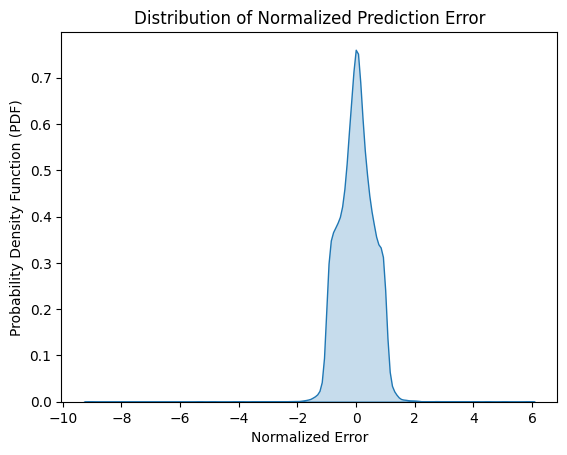

In [ ]:
#make predictions on the training set: 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#recon_model = keras.models.load_model("best_model")
predicted_trained=model1.predict(x_reshaped)
predicted_trained_2d=np.reshape(predicted_trained, (10000, 3))
reel_2d_trained=np.reshape(y_reshaped, (10000, 3))
# calculate correlation between predicted and real data
corr = np.corrcoef(predicted_trained_2d.flatten(), reel_2d_trained.flatten())[0, 1]

# print the correlation value
print("Correlation:", corr)
# Calculate prediction error
prediction_error = predicted_trained_2d - reel_2d_trained
prediction_error_flattened = prediction_error.flatten()
corr = np.corrcoef(predicted_trained_2d.flatten(), reel_2d_trained.flatten())[0, 1]

# Print the correlation value
print("Correlation:", corr)
# Calculate prediction error
prediction_error = predicted_trained_2d - reel_2d_trained
prediction_error_flattened = prediction_error.flatten()

# Calculate norm of reel_2d_trained along axis=1
norm_reel_2d_trained = np.linalg.norm(reel_2d_trained, axis=1)

# Normalize the prediction error
normalized_error = prediction_error_flattened / norm_reel_2d_trained.repeat(3)

# Plot distribution error using density plot
sns.kdeplot(normalized_error, shade=True)
plt.xlabel("Normalized Error")
plt.ylabel("Probability Density Function (PDF)")
plt.title("Distribution of Normalized Prediction Error")
plt.show()


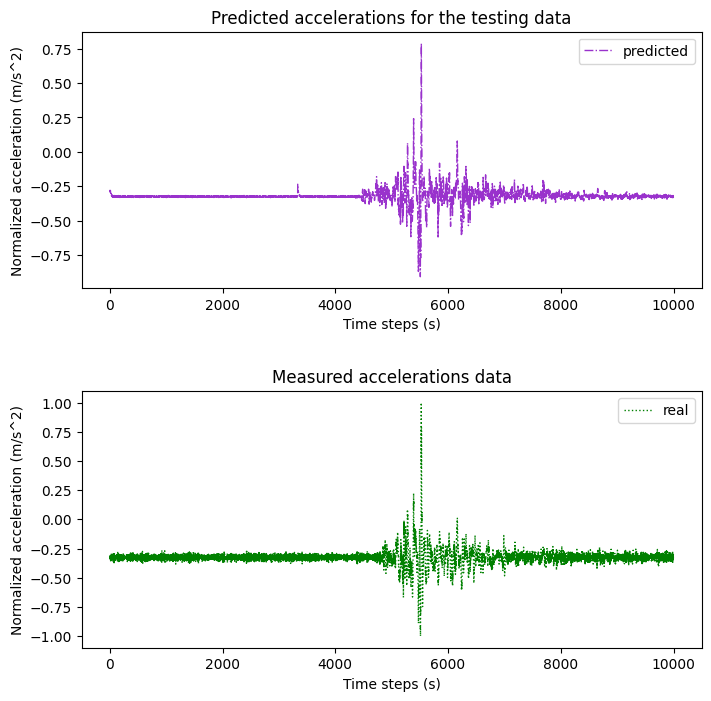

Root Mean Squared Error: 0.03892448


In [ ]:
# create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8,8))

# plot the predicted values
axs[0].plot(predicted_trained_2d[:, 2], c='darkorchid', linestyle='dashdot', label='predicted', linewidth=1)
axs[0].set_title('Predicted accelerations for the testing data')
axs[0].legend()
axs[0].set_xlabel('Time steps (s)')  # set x-axis label
axs[0].set_ylabel('Normalized acceleration (m/s^2)')  # set y-axis label

# plot the real values
axs[1].plot(reel_2d_trained[:, 2], c='green', linestyle='dotted', label='real', linewidth=1)
axs[1].set_title('Measured accelerations data')
axs[1].legend()
axs[1].set_xlabel('Time steps (s)')  # set x-axis label
axs[1].set_ylabel('Normalized acceleration (m/s^2)')  # set y-axis label

# adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)  # set vertical spacing between subplots

# display the plot
plt.show()

rmse = np.sqrt(mean_squared_error(predicted_trained_2d[:, 2], reel_2d_trained[:, 2]))
print('Root Mean Squared Error:', rmse)


In [ ]:
#separate graphs plot


# create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8,8))

# plot the predicted values
axs[0].plot(predicted_trained_2d[:, 1], c='darkorchid', linestyle='dashdot', label='predicted', linewidth=1)
axs[0].set_title('Predicted accelerations for the trained data')
axs[0].legend()

# plot the real values
axs[1].plot(reel_2d_trained[:, 1], c='green', linestyle='dotted', label='real', linewidth=1)
axs[1].set_title('Measured accelerations data')
axs[1].legend()

# display the plot
plt.show()
rmse = np.sqrt(mean_squared_error(predicted_trained_2d[:, 2], reel_2d_trained[:, 2]))
print('Root Mean Squared Error:', rmse)


In [ ]:
print(Vx_reshaped.shape)

(1, 10000, 1)


In [ ]:

# make predictions of the validation dataset: 

predicted_validation=model1.predict(Vx_reshaped)
print(predicted_validation.shape)
predicted_validation_2d=np.reshape(predicted_validation, (10000, 1))
reel_2d_validation=np.reshape(Vy_reshaped, (10000, 1))
# calculate correlation between predicted and real data
corr = np.corrcoef(predicted_validation_2d.flatten(), reel_2d_validation.flatten())[0, 1]

# print the correlation value
print("Correlation:", corr)




1/1 [==============================] - 0s 128ms/step
(1, 10000, 1)
Correlation: 0.13449086005255592


In [ ]:
# calculate root mean squared error
# Flatten the predicted and actual values
#predicted = predicted.flatten()
#y_reshaped = y_reshaped.flatten()

#Calculate the RMSE

rmse = np.sqrt(mean_squared_error(reel_2d_validation,predicted_validation_2d))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.26557553


In [ ]:
# select the column of the arrays
predicted_col = predicted_validation_2d
reel_col = reel_2d_validation


10000


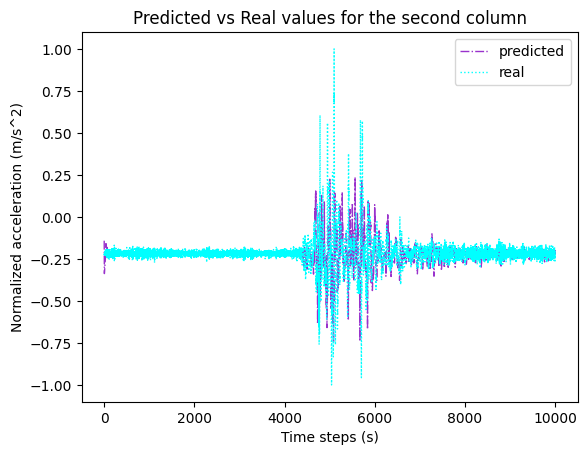

In [ ]:
#same graph plot: 

# plot the two columns
plt.plot(predicted_col, c='darkorchid', linestyle = 'dashdot', label='predicted', linewidth=1)
plt.plot(reel_col, c='cyan', linestyle = 'dotted', label= 'real', linewidth=1)


# set the title and labels
plt.title('Predicted vs Real values for the second column')
plt.xlabel('Time steps (s)')
plt.ylabel('Normalized acceleration (m/s^2)')
print(len(predicted_col))
# show the legend and the plot
plt.legend()
plt.show()


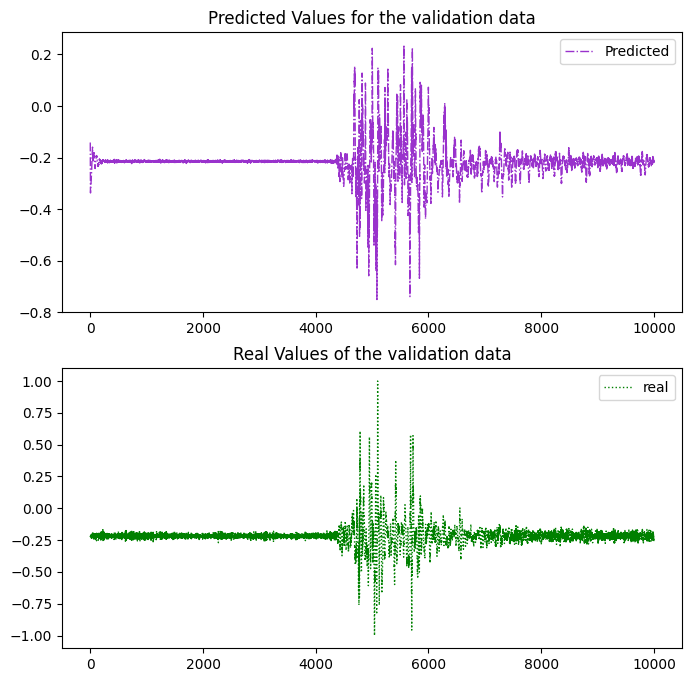

In [ ]:
#separate graphs plot:

# create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(8,8))

# plot the predicted values
axs[0].plot(predicted_col, c='darkorchid', linestyle='dashdot', label='Predicted', linewidth=1)
axs[0].set_title('Predicted Values for the validation data')
axs[0].legend()

# plot the real values
axs[1].plot(reel_col, c='green', linestyle='dotted', label='real', linewidth=1)
axs[1].set_title('Real Values of the validation data')
axs[1].legend()

# display the plot
plt.show()


In [ ]:

# Unit: 50 loss: 0.0081 - val_loss: 0.0083


